# Golden signal based localization (SockShop)

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict, OrderedDict
import pathlib

import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

import sys
sys.path.append("../")

In [4]:
from notebooklib.save import run_tsdr, save_tsdr, load_tsdr

DATASET_ID = "qknmc"
datasets_fluxrank_max_cluster = load_tsdr(DATASET_ID, suffix="fluxrank_max_cluster", revert_normalized_time_series=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


  0%|          | 0/160 [00:00<?, ?it/s]

Green: undirected; Blue: directed; Red: bi-directed



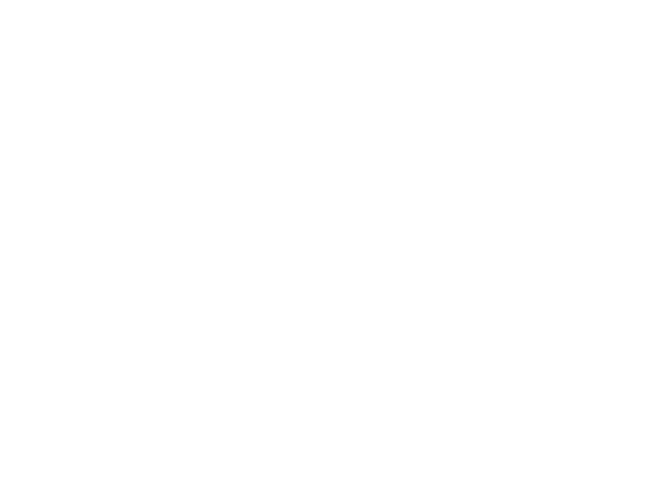

In [19]:
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import gsq, fisherz, mv_fisherz, mc_fisherz 

data_df = datasets_fluxrank_max_cluster[0][-1]
X = data_df.to_numpy(dtype=np.float32)
cg = pc(X, indep_test=gsq, alpha=0.05, node_names=data_df.columns.to_list(), verbose=False)
cg.draw_nx_graph()

In [24]:
from itertools import combinations

from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.graph.GraphNode import GraphNode
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import gsq, fisherz, mv_fisherz, mc_fisherz 


from diagnoser import diag
import diagnoser.metric_node as mn
from meltria.priorknowledge.priorknowledge import SockShopKnowledge


pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewalres": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}},
)

data_df = datasets_fluxrank_max_cluster[0][-1]
data_df = data_df.loc[:, ~data_df.columns.str.startswith("n-")]

# make prior knowledge
nodes = mn.MetricNodes.from_dataframe(data_df)
skel_dg = diag.prepare_init_graph(nodes, pk)
dg = diag.fix_edge_directions_in_causal_graph(skel_dg, pk)
background_knowledge = BackgroundKnowledge()
for node1, node2 in combinations(dg.nodes, 2):
    if not dg.has_edge(node1, node2):
        background_knowledge.add_forbidden_by_node(GraphNode(node2.label), GraphNode(node1.label))
    if not dg.has_edge(node2, node1):
        background_knowledge.add_forbidden_by_node(GraphNode(node1.label), GraphNode(node2.label))

X = data_df.to_numpy(dtype=np.float32)
cg = pc(X, indep_test=fisherz, alpha=0.01, node_names=data_df.columns.to_list(), background_knowledge=background_knowledge, verbose=False, show_progress=True)

  0%|          | 0/151 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
cg.draw_nx_graph()

In [ ]:
# PageRank